# Investment product customer prediction 

## Problem statement

 The objective is to predict the bank customer by targeting the ones who are likely to buy our investment product or not, i.e.    the fraction of prospects who respond to the campaign.

### Importing modules:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"]= (5, 5)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## Importing data :

In [3]:
loan = pd.read_csv(r"G:\python\bank_marketing.csv", sep=",")
loan.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
loan.shape

(41188, 21)

We have around 41K records with 21 columns.

### Checking the dtypes

In [5]:
loan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Target variable is response.

### Checking the nulls 

In [6]:
loan.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
response          0
dtype: int64

There is no null value.

In [7]:
loan.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'response'],
      dtype='object')

## Data exploration of target veriable 

In [8]:
loan['response'].value_counts()

no     36548
yes     4640
Name: response, dtype: int64

<AxesSubplot:xlabel='response', ylabel='count'>

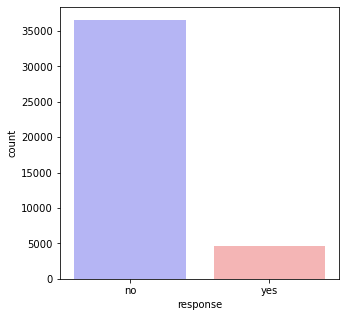

In [9]:
sns.countplot(x= "response" , data = loan , palette= "bwr")

Determine the percentage of people who have bought the investment product, that is those who have the response

In [10]:
loan['response'] = loan['response'].map({'yes': 1, 'no': 0})

In [11]:
(loan['response'].count()/loan['response'].sum()).round(4)

8.8767

### Exploratory Data Analysis

Now, we will do Exploratory Data Analysis on individual features and look for patterns.

First, we will look at the client data.

- Age
- Job : type of job
- Marital : marital status
- Education
- Default: has credit in default?
- Housing: has housing loan?
- Loan: has personal loan?



#### Age

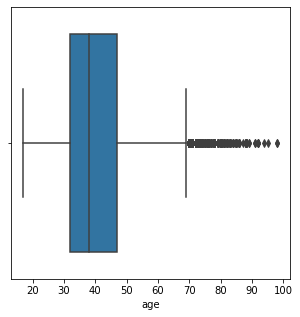

In [12]:
sns.boxplot(x='age', data=loan)
plt.show()

In [13]:
# Since there are a fair few data entries with age > 71, we will club all of those ages at 71 
# (since we can assume  that the behaviour will not change significantly with age at age above 70)
loan['age'][loan['age']>71] =71

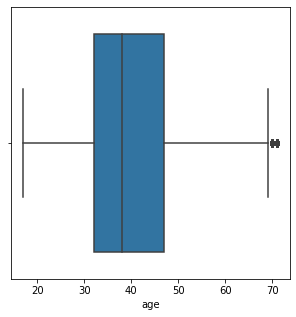

In [14]:
sns.boxplot(x='age', data=loan)
plt.show()

In [15]:
# To understand the behaviour of people with age
# we are going to group the age groups into groups of 10
# study the response rates
bins = np.arange(10,loan['age'].max() + 10, 10)
loan['age_bins'] = pd.cut(loan['age'], bins, include_lowest=True)

### Lets see the relationship between response rate and age 

In [16]:
No_of_prospect = loan.groupby('age_bins')['response'].count().reset_index(name = 'No.of_prospect')
count_prospects = loan[loan['response']==1].groupby('age_bins')['response'].count().reset_index(name = 'count_prospects')
agg_age = No_of_prospect.merge(count_prospects, on='age_bins')
agg_age['response_rate'] = 100*(agg_age['count_prospects']/agg_age['No.of_prospect']).round(3)
agg_age

,age_bins,No.of_prospect,count_prospects,response_rate
0,"(9.999, 20.0]",140,57,40.7
1,"(20.0, 30.0]",7243,1067,14.7
2,"(30.0, 40.0]",16385,1597,9.7
3,"(40.0, 50.0]",10240,837,8.2
4,"(50.0, 60.0]",6270,668,10.7
5,"(60.0, 70.0]",488,212,43.4
6,"(70.0, 80.0]",422,202,47.9


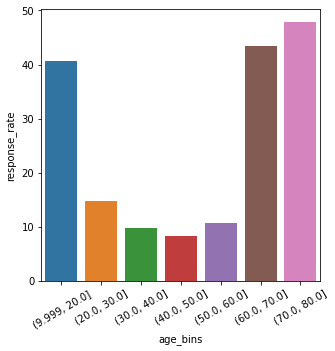

In [17]:
ax = sns.barplot(x='age_bins', y='response_rate', data=agg_age)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

As we can see, the youngest and the eldest are the most likely to buy the investment product being offered by the bank.
Also it is important to note that there is a huge difference in the volume of data entries in these categories.

Similarly, let us look at the relation between response rate and job.

### Lets see the relationship between response rate and job

In [18]:
loan['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [19]:
No_of_prospect_job = loan.groupby('job')['response'].count().reset_index(name = 'No_of_prospects')
count_prospects_job = loan.groupby('job')['response'].sum().reset_index(name = 'count_prospects')
agg_job = No_of_prospect_job.merge(count_prospects_job, on = 'job')
agg_job['response_rate'] = (agg_job['No_of_prospects']/agg_job['count_prospects']).round(4)
agg_job

,job,No_of_prospects,count_prospects,response_rate
0,admin.,10422,1352,7.7086
1,blue-collar,9254,638,14.5047
2,entrepreneur,1456,124,11.7419
3,housemaid,1060,106,10.0000
4,management,2924,328,8.9146
5,retired,1720,434,3.9631
6,self-employed,1421,149,9.5369
7,services,3969,323,12.2879
8,student,875,275,3.1818
9,technician,6743,730,9.2370


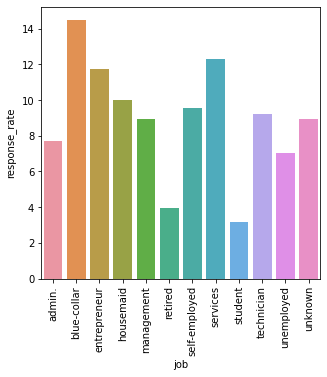

In [20]:
ax = sns.barplot(x='job', y='response_rate', data=agg_job)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

We can draw similarities from the age response analysis where we found that the youngest and eldest were most likely to respond in a negative manner. It is reiterated by the above analysis, where we notice that student and retired have the highest response rates.

### Relationship between Response rate and Marital .

In [21]:
loan['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

Since there are 80 entries which list marital status as 'unknown', we will assign them to the biggest group, which is, 'married'.

In [22]:
loan.replace({'marital' : { 'unknown' : 'married'}}, inplace=True)
count_prospects_marital = loan.groupby('marital')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_job = loan.groupby('marital')['response'].count().reset_index(name = 'No_of_prospects')
agg_marital = count_prospects_marital.merge(No_of_prospect_job, on = 'marital')
agg_marital['response_rate'] = 100*(agg_marital['count_prospects']/agg_marital['No_of_prospects']).round(4)
agg_marital

,marital,count_prospects,No_of_prospects,response_rate
0,divorced,476,4612,10.32
1,married,2544,25008,10.17
2,single,1620,11568,14.00


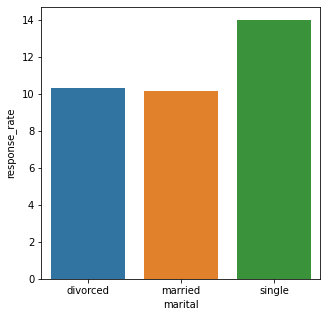

In [23]:
ax = sns.barplot(x='marital', y='response_rate', data=agg_marital)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We note that there is a slight uptick in response rate for single customers, this can be attributed in part to the fact that people under the age of 25 have a very high response rate. 

### Relationship between Response rate and  Education

In [24]:
loan.replace({'education' : { 'basic.9y' : 'Primary_Education', 'basic.4y' : 'Primary_Education','basic.6y' : 'Primary_Education','illiterate' : 'Primary_Education',
                             'high.school' : 'Secondary_Education', 'university.degree' : 'Tertiary_Education' }}, inplace=True)

In [25]:
count_prospects_education = loan.groupby('education')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_education = loan.groupby('education')['response'].count().reset_index(name = 'No_of_prospects')
agg_education = count_prospects_education.merge(No_of_prospect_education, on = 'education')
agg_education['response_rate'] = 100*(agg_education['count_prospects']/agg_education['No_of_prospects']).round(4)
agg_education

,education,count_prospects,No_of_prospects,response_rate
0,Primary_Education,1093,12531,8.72
1,Secondary_Education,1031,9515,10.84
2,Tertiary_Education,1670,12168,13.72
3,professional.course,595,5243,11.35
4,unknown,251,1731,14.50


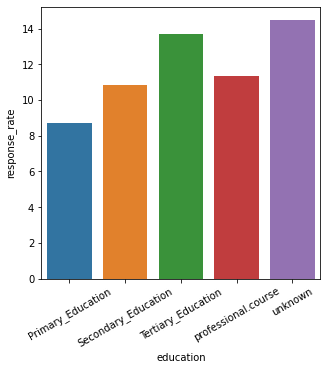

In [26]:
ax = sns.barplot(x='education', y='response_rate', data=agg_education)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

We note that the response rate is lowest for people with highest education, qualification as primary education, which may be attributed, in part, to lack of awareness and a lack of trust between the bank and the customer. It is the highest for people with tertiary education.

### Relationship between Response rate and Previous Default by months 

In [27]:
count_prospects_month = loan.groupby('month')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_month = loan.groupby('month')['response'].count().reset_index(name = 'No_of_prospects')
agg_month = count_prospects_month.merge(No_of_prospect_month, on = 'month')
agg_month['response_rate'] = 100*(agg_month['count_prospects']/agg_month['No_of_prospects']).round(4)
agg_month

,month,count_prospects,No_of_prospects,response_rate
0,apr,539,2632,20.48
1,aug,655,6178,10.60
2,dec,89,182,48.90
3,jul,649,7174,9.05
4,jun,559,5318,10.51
5,mar,276,546,50.55
6,may,886,13769,6.43
7,nov,416,4101,10.14
8,oct,315,718,43.87
9,sep,256,570,44.91


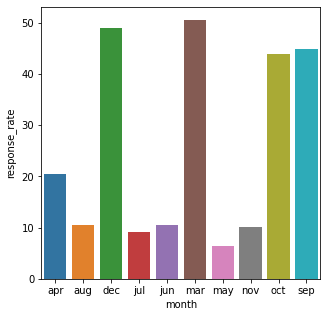

In [28]:
ax = sns.barplot(x='month', y='response_rate', data=agg_month)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We note that the four months of december, march, october and september appear to be the best to contact the potential customers. However, these months have the fewest data entries as well, so it is not certain, how well it would behave when calls are made at a high volume.

#### Day of the week

In [29]:
count_prospects_day = loan.groupby('day_of_week')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_day = loan.groupby('day_of_week')['response'].count().reset_index(name = 'No_of_prospects')
agg_day = count_prospects_day.merge(No_of_prospect_day, on = 'day_of_week')
agg_day['response_rate'] = 100*(agg_day['count_prospects']/agg_day['No_of_prospects']).round(4)
agg_day

,day_of_week,count_prospects,No_of_prospects,response_rate
0,fri,846,7827,10.81
1,mon,847,8514,9.95
2,thu,1045,8623,12.12
3,tue,953,8090,11.78
4,wed,949,8134,11.67


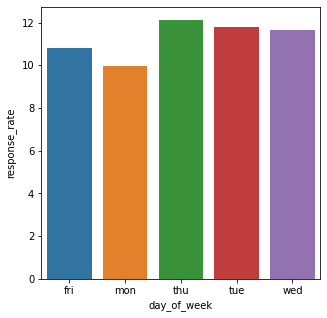

In [30]:
ax = sns.barplot(x='day_of_week', y='response_rate', data=agg_day)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We see that response rate is lowest on monday, while being highest on thursday. However, the gap isn't very big.

### Now we have looked at client data and the data related to last contact, we will look at some of the other attributes.


#### Response Rate after each Campaign

Campaign : number of contacts performed during this campaign and for this client

In [31]:
loan['campaign'][loan['campaign']>14] =14

In [32]:
count_prospects_campaign = loan.groupby('campaign')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_campaign = loan.groupby('campaign')['response'].count().reset_index(name = 'No_of_prospects')
agg_campaign = count_prospects_campaign.merge(No_of_prospect_campaign, on = 'campaign')
agg_campaign['response_rate'] = 100*(agg_campaign['count_prospects']/agg_campaign['No_of_prospects']).round(4)
agg_campaign

,campaign,count_prospects,No_of_prospects,response_rate
0,1,2300,17642,13.04
1,2,1211,10570,11.46
2,3,574,5341,10.75
3,4,249,2651,9.39
4,5,120,1599,7.50
5,6,75,979,7.66
6,7,38,629,6.04
7,8,17,400,4.25
8,9,17,283,6.01
9,10,12,225,5.33


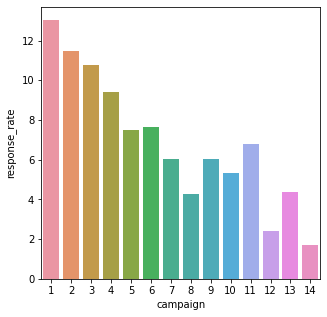

In [33]:
ax = sns.barplot(x='campaign', y='response_rate', data=agg_campaign)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

Interesting to note, that the response rate gradually decreases as the number of campaign contacts increases.

#### Relationship between Response rate based on no of calls contacted

Pdays: number of days that passed by after the client was last contacted from a previous campaign

We are going to divide the pdays into three buckets, that is contacted within the first ten days, contacted after first ten days and first time contacted. Note that the pdays value of 999 means client was not previously contacted.

In [34]:
loan['pdays'][loan['pdays'].isin([0,1,2,3,4,5,6,7,8,9,10])]='Contacted_in_first_10days'

loan['pdays'][loan['pdays'].isin([999])]='First_time_contacted'

loan['pdays'][~loan['pdays'].isin(['Contacted_in_first_10days','First_time_contacted'])]='Contacted_after_10days'

In [35]:
loan['pdays'].value_counts()

First_time_contacted         39673
Contacted_in_first_10days     1311
Contacted_after_10days         204
Name: pdays, dtype: int64

In [36]:
count_prospects_pdays = loan.groupby('pdays')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_pdays = loan.groupby('pdays')['response'].count().reset_index(name = 'No_of_prospects')
agg_pdays = count_prospects_pdays.merge(No_of_prospect_pdays, on = 'pdays')
agg_pdays['response_rate'] = 100*(agg_pdays['count_prospects']/agg_pdays['No_of_prospects']).round(4)
agg_pdays

,pdays,count_prospects,No_of_prospects,response_rate
0,Contacted_after_10days,116,204,56.86
1,Contacted_in_first_10days,851,1311,64.91
2,First_time_contacted,3673,39673,9.26


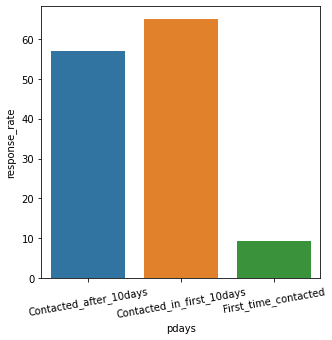

In [37]:
ax = sns.barplot(x='pdays', y='response_rate', data=agg_pdays)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
plt.show()

Though there is a huge difference in the response rates of the three categories, it is important to note that there is also a huge difference in the volume of data entries in these categories

#### Relationship based on previous contacted person and their response

Previous: number of contacts performed before this campaign and for this client

In [38]:
loan['previous'].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

Since the data ranges from 0 to 7, we are going to break it into three categories, that is never contacted, contacted less than three times and contacted greater than three times

In [39]:
loan['previous'][loan['previous'].isin([0])]='Never contacted'
loan['previous'][loan['previous'].isin([1,2,3])]='Less_than_3_times'
loan['previous'][loan['previous'].isin([4,5,6,7])]='More than_3_times'

In [40]:
loan['previous'].value_counts()

Never contacted      35563
Less_than_3_times     5531
More than_3_times       94
Name: previous, dtype: int64

In [41]:
count_prospects_previous = loan.groupby('previous')['response'].sum().reset_index(name = 'count_prospects')
No_of_prospect_previous = loan.groupby('previous')['response'].count().reset_index(name = 'No_of_prospects')
agg_previous = count_prospects_previous.merge(No_of_prospect_previous, on = 'previous')
agg_previous['response_rate'] = 100*(agg_previous['count_prospects']/agg_previous['No_of_prospects']).round(4)
agg_previous

,previous,count_prospects,No_of_prospects,response_rate
0,Less_than_3_times,1445,5531,26.13
1,More than_3_times,54,94,57.45
2,Never contacted,3141,35563,8.83


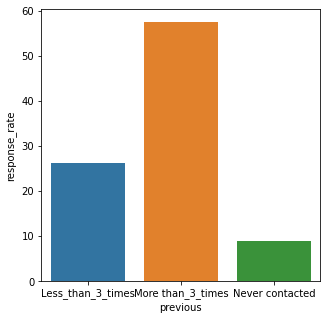

In [42]:
ax = sns.barplot(x='previous', y='response_rate', data=agg_previous)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

We can note that the response rate is greatest for the the potential customers having previous contact of more than three. However,the number of data entries is very low for such cases, hence it's difficult to draw any inferences.

### Correlation metrics

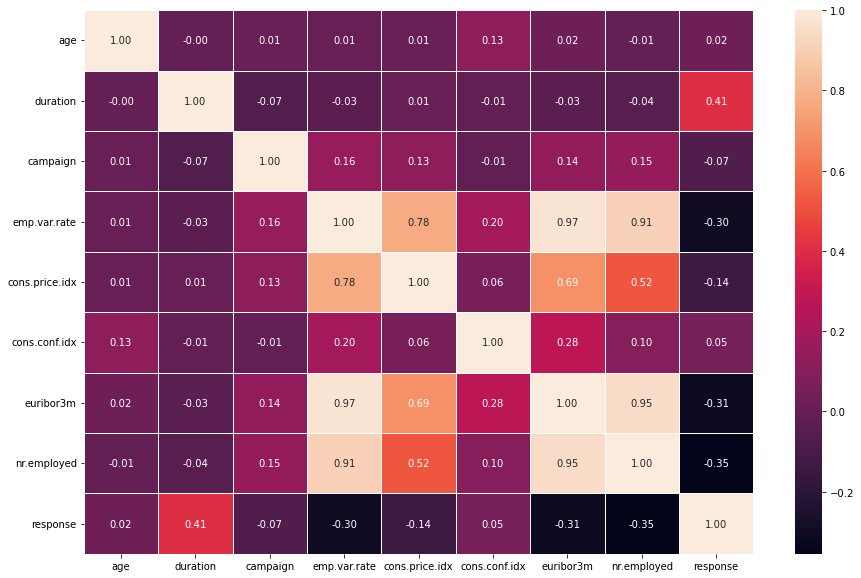

In [43]:
corr_matrix=loan.corr()
fig,ax=plt.subplots(figsize=(15,10))
ax=sns.heatmap(corr_matrix,
               annot=True,
               linewidths=0.5,
               fmt=".2f"
              )

Now that we have completed basic exploratory analysis, we can move to the next stage, that is data preparation

#### Data Preparation

In [44]:
loan.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'response', 'age_bins'],
      dtype='object')

#### Drop the tables 

In [45]:
loan = loan.drop(columns =['age_bins','duration'],axis =1) 

In [46]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  object 
 12  previous        41188 non-null  object 
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

#### Label Encoding

In [47]:
loan[loan.select_dtypes(include=['object']).columns] = loan[loan.select_dtypes(include=['object']).columns].apply(le.fit_transform)

In [48]:
#ispecting the df
loan.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,3,1,0,0,0,0,1,6,1,1,2,2,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,1,1,0,0,1,6,1,1,2,2,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,1,0,2,0,1,6,1,1,2,2,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,0,0,0,0,1,6,1,1,2,2,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,1,0,0,2,1,6,1,1,2,2,1,1.1,93.994,-36.4,4.857,5191.0,0


Now that the data preparation step is complete, we will jump straight into sampling:

### Sampling:

In [49]:
# Import library to split the dataset into test and train
from sklearn.model_selection import train_test_split

In [50]:
loan_train , loan_test = train_test_split(loan , test_size=.2 )

In [51]:
lon_train_x = loan_train.iloc[:,0:-1]
lon_train_y = loan_train.iloc[:,-1]

In [52]:
loan_test_x = loan_test.iloc[:,0:-1]
loan_test_y = loan_test.iloc[:,-1]


Sampling is done lets move towards the standardization

### Class Imbalancing

We have imbalanced classes so we do the oversampling at here 

In [53]:
from imblearn.combine import SMOTETomek

In [54]:
df2 = loan[loan['response']==1]
df3 = loan[loan['response']==0]

In [55]:
print(df2.shape , df3.shape)

(4640, 20) (36548, 20)


In [56]:
# implamenting undersampling for handing imbalanced
und = SMOTETomek(random_state=42)
loan_train_x , loan_train_y = und.fit_resample(lon_train_x,lon_train_y)

In [57]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(lon_train_y)))
print('Resampled dataset shape {}'.format(Counter(loan_train_y)))

Original dataset shape Counter({0: 29210, 1: 3740})
Resampled dataset shape Counter({0: 29046, 1: 29046})


### Standardization

In [58]:
loan_train_x.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,47,1,1,3,0,0,2,0,4,3,2,2,2,1,-2.9,92.963,-40.8,1.206,5076.2
1,50,0,2,0,0,1,1,1,7,2,1,2,2,1,-0.1,93.200,-42.0,4.245,5195.8
2,55,0,0,2,0,2,0,0,0,4,1,2,2,1,-1.8,93.075,-47.1,1.445,5099.1
3,33,6,1,2,0,0,0,1,6,3,1,2,2,1,1.1,93.994,-36.4,4.857,5191.0
4,34,6,1,3,0,2,0,0,7,4,3,2,0,0,-0.1,93.200,-42.0,4.120,5195.8


In [59]:
# Standardisation continuous features for X_train
col_list = ['age','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

In [60]:
scaler = StandardScaler()
loan_train_x[col_list]=scaler.fit_transform(loan_train_x[col_list])

In [61]:
loan_train_x.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,5.809200e+04,58092.000000,58092.000000,58092.000000,58092.000000,58092.000000,58092.000000,58092.000000,58092.000000,58092.000000,5.809200e+04,58092.000000,58092.000000,58092.000000,5.809200e+04,5.809200e+04,5.809200e+04,5.809200e+04,5.809200e+04
mean,-2.984317e-16,3.749501,1.124527,1.317428,0.130001,1.010897,0.261809,0.246247,4.189888,1.893135,7.693494e-14,1.827859,1.523514,0.934139,-1.005926e-15,9.803698e-15,-1.485389e-15,-6.596650e-15,-5.453203e-14
std,1.000009e+00,3.596061,0.610219,1.093852,0.336461,0.953590,0.632275,0.430828,2.495029,1.339797,1.000009e+00,0.425322,0.823378,0.442450,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-2.011390e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.748738e-01,0.000000,0.000000,0.000000,-1.686412e+00,-2.021972e+00,-1.977743e+00,-1.228329e+00,-1.967359e+00
25%,-7.887383e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,-5.748738e-01,2.000000,1.000000,1.000000,-7.573194e-01,-9.283405e-01,-4.687615e-01,-9.059892e-01,-6.757265e-01
50%,-2.647448e-01,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000,2.000000,-5.748738e-01,2.000000,2.000000,1.000000,2.298418e-01,-5.754420e-02,-3.010968e-01,5.614487e-01,6.411426e-01
75%,6.959098e-01,7.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0.000000,6.000000,3.000000,-6.809713e-02,2.000000,2.000000,1.000000,1.100866e+00,8.116717e-01,7.048909e-01,1.057112e+00,1.066716e+00
max,2.704551e+00,11.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,6.013222e+00,2.000000,2.000000,2.000000,1.100866e+00,2.033315e+00,2.474684e+00,1.102556e+00,1.066716e+00


In [62]:
# Standardisation continuous features for X_test
loan_test_x[col_list] = scaler.transform(loan_test_x[col_list])

Standardization is done lets move towards the modelling

### Modelling


In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [64]:
lr=LogisticRegression()
dt=DecisionTreeClassifier()
rm=RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=3)
svm = svm.SVC(kernel='linear')

In [65]:
for a,b in zip([lr,dt,knn,svm,rm],["Logistic Regression","Decision Tree","KNN","SVM","Random Forest"]):
    a.fit(loan_train_x,loan_train_y)
    prediction=a.predict(loan_train_x)
    y_pred=a.predict(loan_test_x)
    score1=accuracy_score(loan_train_y,prediction)
    score=accuracy_score(loan_test_y,y_pred)
    msg1="[%s] training data accuracy is : %f" % (b,score1)
    msg2="[%s] test data accuracy is : %f" % (b,score)
    print(msg1)
    print(msg2)

[Logistic Regression] training data accuracy is : 0.771414
[Logistic Regression] test data accuracy is : 0.780772
[Decision Tree] training data accuracy is : 0.995937
[Decision Tree] test data accuracy is : 0.813183
[KNN] training data accuracy is : 0.933227
[KNN] test data accuracy is : 0.779558
[SVM] training data accuracy is : 0.753529
[SVM] test data accuracy is : 0.829085
[Random Forest] training data accuracy is : 0.995920
[Random Forest] test data accuracy is : 0.872056


- We can say that in decision tree , random forest there is a problem of overfitting  based on train test diffrence.

Lets move towards the model evalution

# Evalution of every machine learning model 

#### Evalution of the logistic learning model 

In [66]:
lr_y_preds = lr.predict(loan_test_x)
print(classification_report(loan_test_y,lr_y_preds))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87      7338
           1       0.27      0.58      0.37       900

    accuracy                           0.78      8238
   macro avg       0.60      0.69      0.62      8238
weighted avg       0.87      0.78      0.81      8238



for logistic regression the f1 score is 62 %

#### Evalution of the decision tree model 

In [67]:
dt_y_preds = dt.predict(loan_test_x)
print(classification_report(loan_test_y,dt_y_preds))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7338
           1       0.27      0.40      0.32       900

    accuracy                           0.81      8238
   macro avg       0.59      0.63      0.61      8238
weighted avg       0.85      0.81      0.83      8238



for the decision tree the f1 score is 62%

#### Evalution of the random forest model 

In [68]:
rm_y_preds = rm.predict(loan_test_x)
print(classification_report(loan_test_y,rm_y_preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7338
           1       0.42      0.43      0.42       900

    accuracy                           0.87      8238
   macro avg       0.67      0.68      0.68      8238
weighted avg       0.87      0.87      0.87      8238



for Random forest the f1 score is 67 % 

#### Evalution of the k nearest neibour model 

In [69]:
knn_y_preds = knn.predict(loan_test_x)
print(classification_report(loan_test_y, knn_y_preds))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      7338
           1       0.25      0.52      0.34       900

    accuracy                           0.78      8238
   macro avg       0.59      0.67      0.60      8238
weighted avg       0.86      0.78      0.81      8238



for k nearest neighbour the f1 score is 60 %

#### Evalution of the support vector machine model 

In [70]:
svm_y_preds = svm.predict(loan_test_x)
print(classification_report(loan_test_y, svm_y_preds))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7338
           1       0.34      0.58      0.42       900

    accuracy                           0.83      8238
   macro avg       0.64      0.72      0.66      8238
weighted avg       0.88      0.83      0.85      8238



for svm the f1 score is 67 %

### From the above model evavulation we got a best f1 score for support vector machine and Random forest 

In [71]:
model_scores={'Logistic Regression':lr.score(loan_test_x,loan_test_y),
             'KNN classifier':knn.score(loan_test_x,loan_test_y),
             'Support Vector Machine':svm.score(loan_test_x,loan_test_y),
             'Random forest':rm.score(loan_test_x,loan_test_y),
              'Decision tree':dt.score(loan_test_x,loan_test_y)
             }
model_scores

{'Logistic Regression': 0.7807720320466133,
 'KNN classifier': 0.7795581451808692,
 'Support Vector Machine': 0.829084729303229,
 'Random forest': 0.8720563243505706,
 'Decision tree': 0.8131828113619811}

In [72]:
model_compare = pd.DataFrame(model_scores,index=['accuracy'])
model_compare 

,Logistic Regression,KNN classifier,Support Vector Machine,Random forest,Decision tree
accuracy,0.780772,0.779558,0.829085,0.872056,0.813183


<AxesSubplot:>

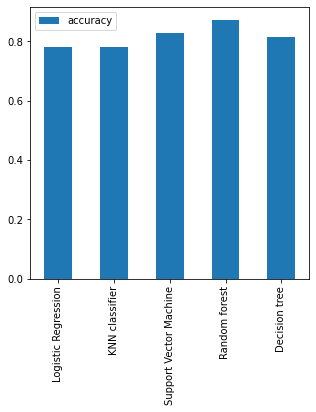

In [73]:
model_compare.T.plot(kind='bar') 


- Random forest and support vector machine gives best testing accuracy 
- To inhance the performance and to reduce overfitting we used grid search cv

In [74]:
loan.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'response'],
      dtype='object')

###  We got best f1 score  on random forest and svm so we take it for further with hyperparameter tunning. 

#### Random forest algorithm using Grid_search_cv 

In [75]:
from boruta import BorutaPy

In [76]:
search_dict = {"n_estimators": (10,15,20,25,30),
               "criterion": ["gini","entropy"],
              "max_depth": (5,6,7,8),
              "min_samples_split":(50,15,100,150)}

In [77]:
grid = GridSearchCV(rm, param_grid = search_dict)
grid.fit(loan_train_x,loan_train_y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': (5, 6, 7, 8),
                         'min_samples_split': (50, 15, 100, 150),
                         'n_estimators': (10, 15, 20, 25, 30)})

In [78]:
grid.best_params_  

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 15,
 'n_estimators': 25}

we got best parameter and creating a Random forest using those parameter 

In [79]:
rf = RandomForestClassifier(criterion='gini',n_estimators=10, max_depth=8 , min_samples_split=15 )

In [80]:
rf.fit(loan_train_x,loan_train_y)

RandomForestClassifier(max_depth=8, min_samples_split=15, n_estimators=10)

In [81]:
predict=rf.predict(loan_train_x)

In [82]:
pred_loan =  rf.predict(loan_test_x)
pred_loan

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [83]:
train_rf=accuracy_score(loan_train_y,predict)
print("Random forest classifier accuracy for training",train_rf)

Random forest classifier accuracy for training 0.7941024581697996


In [84]:
test_rf=accuracy_score(loan_test_y,pred_loan)
print("Random forest classifier accuracy for testing",test_rf)

Random forest classifier accuracy for testing 0.8241077931536781


In [85]:
precision_score(loan_test_y,pred_loan)


0.3314917127071823

In [86]:
recall_score(loan_test_y,pred_loan)

0.6

In [87]:
rf_f1 = f1_score(loan_test_y,pred_loan)

In [88]:
rf.feature_importances_

array([0.01042778, 0.00574949, 0.00913609, 0.01091779, 0.06036193,
       0.02492904, 0.02363853, 0.04661524, 0.02306964, 0.00923459,
       0.02482323, 0.06612702, 0.00952818, 0.00770911, 0.18722018,
       0.07301816, 0.03961424, 0.24014779, 0.12773195])

In [89]:
rf_imp = pd.DataFrame({'feature':loan_train_x.columns,"importances": rf.feature_importances_})

In [90]:
rf_imp.sort_values("importances",ascending=False)

,feature,importances
17,euribor3m,0.240148
14,emp.var.rate,0.187220
18,nr.employed,0.127732
15,cons.price.idx,0.073018
11,pdays,0.066127
4,default,0.060362
7,contact,0.046615
16,cons.conf.idx,0.039614
5,housing,0.024929
10,campaign,0.024823


nr.employed , euribor3m , emp.var.rate are the most important parameters to us for Random forest

#### Support vector machine using Grid_search_cv

In [91]:
search_dict ={"kernel": ['linear', 'rbf', 'sigmoid']}

In [92]:
from sklearn import svm

In [93]:
svc_loan = svm.SVC()

In [94]:
sv = GridSearchCV(svc_loan,param_grid= search_dict)
sv.fit(loan_train_x,loan_train_y)

GridSearchCV(estimator=SVC(),
             param_grid={'kernel': ['linear', 'rbf', 'sigmoid']})

In [95]:
sv.best_params_

{'kernel': 'rbf'}

In [96]:
pred_grid = sv.predict(loan_test_x)
pred_grid

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [97]:
predict1=sv.predict(loan_train_x)

In [98]:
train_sv=accuracy_score(loan_train_y,predict1)
print("support vector machine model accuracy for training is ",train_sv)

support vector machine model accuracy for training is  0.7931212559388556


In [99]:
test_sv=accuracy_score(loan_test_y,pred_grid)
print("support vector machine model accuracy for testing is ",test_sv)

support vector machine model accuracy for testing is  0.812575867929109


In [100]:
precision_score(loan_test_y,pred_grid)

0.31103286384976525

In [101]:
recall_score(loan_test_y,pred_grid)

0.5888888888888889

In [102]:
f1_svm =f1_score(loan_test_y,pred_grid)

In [103]:
compare={'Random forest train accuracy':train_rf ,
         'Random forest test accuracy':test_rf,
         'svm train accuracy':train_sv,
         'svm test accuracy':test_sv
        }
compare

{'Random forest train accuracy': 0.7941024581697996,
 'Random forest test accuracy': 0.8241077931536781,
 'svm train accuracy': 0.7931212559388556,
 'svm test accuracy': 0.812575867929109}

- We can see that there is no problem of overfitting in Random forest 
- Their is  training accuracy slighly better than testing accuracy the data is imbalanced so that why this diffrence is happen  

In [104]:
best=pd.DataFrame(compare,index=['accuracy'])
best

,Random forest train accuracy,Random forest test accuracy,svm train accuracy,svm test accuracy
accuracy,0.794102,0.824108,0.793121,0.812576


 Random Forest algorithm have slighly better accuracy Support vector machine .

<AxesSubplot:>

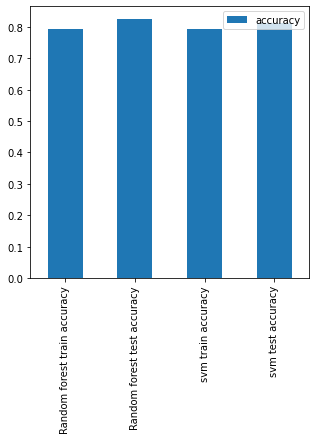

In [105]:
best.T.plot(kind='bar') 

In [107]:
f1_com ={'F1_score for random forest':rf_f1,
        'f1_score for svm':f1_svm
        }
f1_com

{'F1_score for random forest': 0.42704626334519574,
 'f1_score for svm': 0.40706605222734255}

In [111]:
best1=pd.DataFrame(f1_com,index=['F1_score'])
best1

,F1_score for random forest,f1_score for svm
F1_score,0.427046,0.407066


<AxesSubplot:>

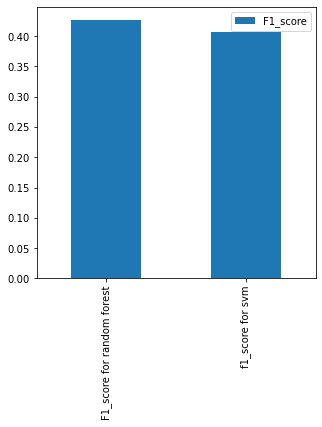

In [112]:
best1.T.plot(kind='bar') 

## Observation

* In Random forest we got f1_score around 43%
* Random forest testing accuracy is 85 % 
* In Support vector machine the f1_score is 41%
* Support vector machine testing accuracy is 81% 



### Result 

From the above Observation the  best of the them is random forest and the anather option is svm .


### Model implementation

In [114]:
import pickle
saved_model = pickle.dumps(rf)
lr_from_pickle = pickle.loads(saved_model)
lr_from_pickle.predict(loan_test_x)

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [115]:
import joblib
joblib.dump(grid , 'model_lr')
m_jlib = joblib.load('model_lr')
m_jlib.predict(loan_test_x) 

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)